# Understanding Neural Networks: From Pixels to Predictions

*A visual guide to how neural networks learn, using edge detection as our example*

---

Neural networks can seem intimidating. Terms like "cross-entropy loss," "softmax," and "backpropagation" sound complex. But at their core, these are just clever combinations of simple operations.

This tutorial explains **how neural networks learn** — specifically, how they automatically discover the right weights through training. We'll use **edge detection** as our running example: training a network to look at a small image patch and answer "Is there a vertical edge here?"

By the end, you'll understand:
- How a neuron detects patterns (like edges)
- How we measure "wrongness" with the loss function  
- How backpropagation computes gradients
- How gradient descent learns the right weights

**Companion post:** For a deeper dive into how a single neuron works as a pattern detector (weights, ReLU, bias), see [How Neural Networks Learn to See: Building an Edge Detector from Scratch](https://snowch.github.io/nn_edge_detector_blog.html). This tutorial focuses on the *training* process — how the network discovers those weights automatically.


In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = False


---

## Part 1: The Problem - Detecting Edges

Let's start with a concrete task. Given a 5x5 grayscale image patch, we want to classify it:
- **Class 0: "Edge"** - there's a vertical edge (dark-to-bright transition)
- **Class 1: "No Edge"** - uniform or other pattern

Here are some examples:


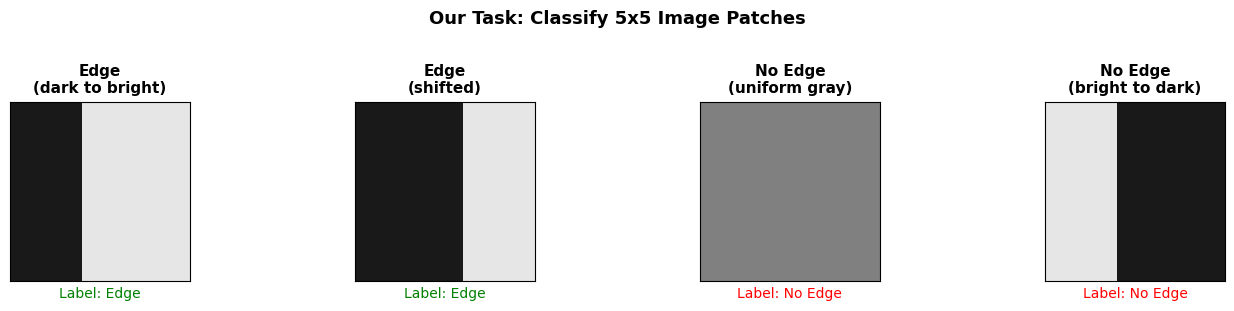

In [2]:
# Show example image patches
fig, axes = plt.subplots(1, 4, figsize=(14, 3))

examples = [
    ("Edge\n(dark to bright)", [[0.1, 0.1, 0.9, 0.9, 0.9]]*5, "Edge"),
    ("Edge\n(shifted)", [[0.1, 0.1, 0.1, 0.9, 0.9]]*5, "Edge"),
    ("No Edge\n(uniform gray)", [[0.5, 0.5, 0.5, 0.5, 0.5]]*5, "No Edge"),
    ("No Edge\n(bright to dark)", [[0.9, 0.9, 0.1, 0.1, 0.1]]*5, "No Edge"),
]

for ax, (title, pixels, label) in zip(axes, examples):
    img = np.array(pixels)
    ax.imshow(img, cmap='gray', vmin=0, vmax=1)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel(f'Label: {label}', fontsize=10, 
                  color='green' if label == "Edge" else 'red')
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle('Our Task: Classify 5x5 Image Patches', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### The Network's Job

Our neural network will:
1. Take 25 pixel values as input (the 5x5 patch flattened)
2. Process them through weights and activations
3. Output two scores: one for "Edge", one for "No Edge"
4. Convert scores to probabilities using **softmax**
5. Compare to the true label using the **loss function**

Let's build up each piece.


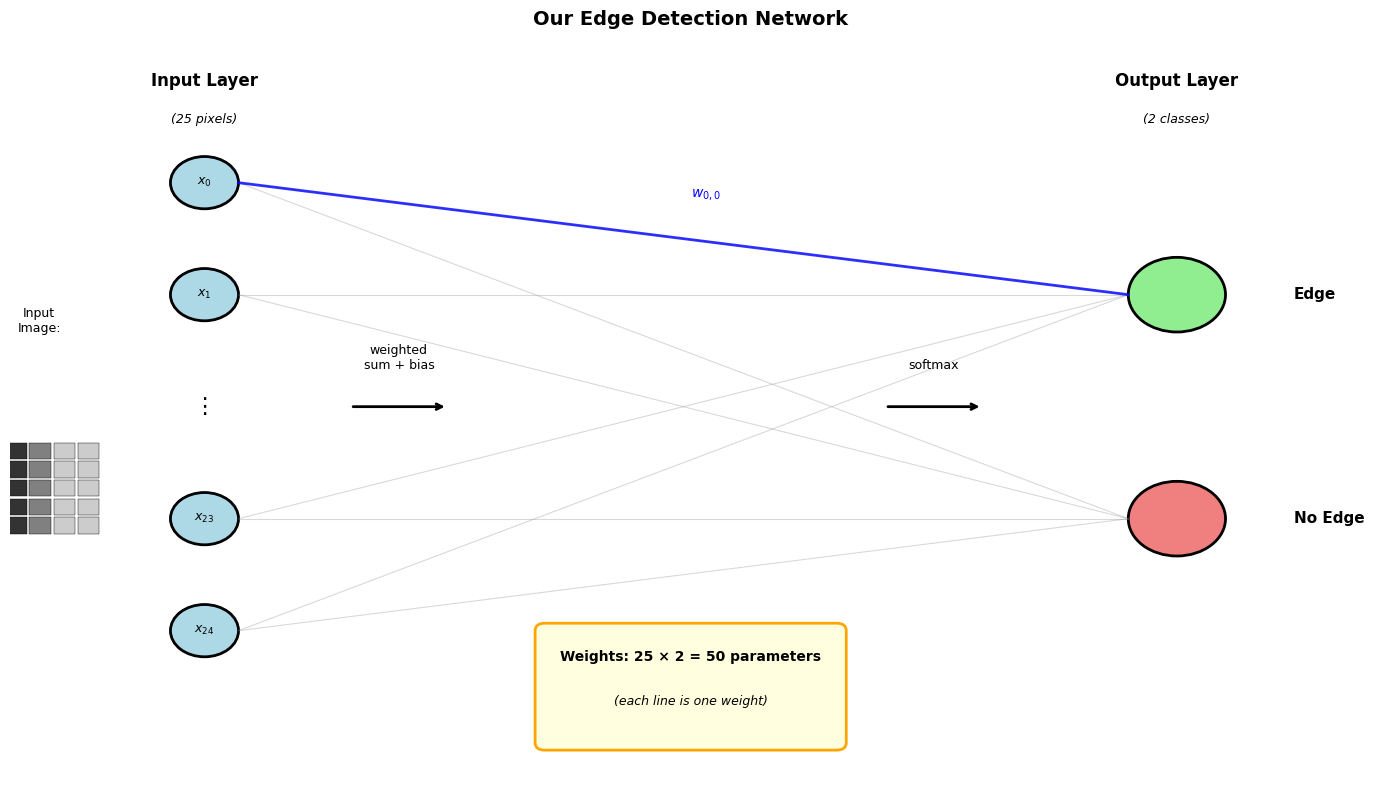

Each input pixel connects to BOTH output neurons.
The network learns 50 weights (25 inputs × 2 outputs) + 2 biases = 52 parameters total.


In [3]:
# Network architecture diagram with nodes and connections
fig, ax = plt.subplots(figsize=(14, 8))
ax.set_xlim(0, 14)
ax.set_ylim(0, 10)
ax.axis('off')
ax.set_title('Our Edge Detection Network', fontsize=14, fontweight='bold')

# Define layer positions
input_x = 2
hidden_x = 7  # We'll show a simplified view
output_x = 12

# Input layer - show 5 nodes with "..." to indicate 25 total
input_ys = [8, 6.5, 5, 3.5, 2]
input_labels = ['$x_0$', '$x_1$', '...', '$x_{23}$', '$x_{24}$']

ax.text(input_x, 9.3, 'Input Layer', fontsize=12, fontweight='bold', ha='center')
ax.text(input_x, 8.8, '(25 pixels)', fontsize=9, ha='center', style='italic')

for y, label in zip(input_ys, input_labels):
    if label == '...':
        ax.text(input_x, y, '⋮', fontsize=16, ha='center', va='center')
    else:
        circle = plt.Circle((input_x, y), 0.35, color='lightblue', ec='black', linewidth=2)
        ax.add_patch(circle)
        ax.text(input_x, y, label, fontsize=9, ha='center', va='center')

# Output layer - 2 nodes
output_ys = [6.5, 3.5]
output_labels = ['Edge', 'No Edge']
output_colors = ['lightgreen', 'lightcoral']

ax.text(output_x, 9.3, 'Output Layer', fontsize=12, fontweight='bold', ha='center')
ax.text(output_x, 8.8, '(2 classes)', fontsize=9, ha='center', style='italic')

for y, label, color in zip(output_ys, output_labels, output_colors):
    circle = plt.Circle((output_x, y), 0.5, color=color, ec='black', linewidth=2)
    ax.add_patch(circle)
    ax.text(output_x + 1.2, y, label, fontsize=11, ha='left', va='center', fontweight='bold')

# Draw connections (weights) - from each input to each output
for in_y in input_ys:
    if in_y == 5:  # skip the "..." 
        continue
    for out_y in output_ys:
        ax.plot([input_x + 0.35, output_x - 0.5], [in_y, out_y], 
                'gray', alpha=0.3, linewidth=0.8)

# Highlight one connection
ax.plot([input_x + 0.35, output_x - 0.5], [input_ys[0], output_ys[0]], 
        'blue', alpha=0.8, linewidth=2)
ax.text(7, 7.8, '$w_{0,0}$', fontsize=10, color='blue', fontweight='bold')

# Weights annotation
ax.add_patch(mpatches.FancyBboxPatch((5.5, 0.5), 3, 1.5, boxstyle='round,pad=0.1',
                                      facecolor='lightyellow', edgecolor='orange', linewidth=2))
ax.text(7, 1.6, 'Weights: 25 × 2 = 50 parameters', fontsize=10, ha='center', fontweight='bold')
ax.text(7, 1.0, '(each line is one weight)', fontsize=9, ha='center', style='italic')

# Show the computation flow
ax.annotate('', xy=(4.5, 5), xytext=(3.5, 5),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))
ax.annotate('', xy=(10, 5), xytext=(9, 5),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))

# Labels for computation
ax.text(4, 5.5, 'weighted\nsum + bias', fontsize=9, ha='center')
ax.text(9.5, 5.5, 'softmax', fontsize=9, ha='center')

# Add mini input image on the left
ax.text(0.3, 6, 'Input\nImage:', fontsize=9, ha='center')
for row in range(5):
    for col in range(5):
        color = '0.2' if col < 2 else ('0.5' if col == 2 else '0.8')
        rect = plt.Rectangle((-0.3 + col*0.25, 4.3 - row*0.25), 0.22, 0.22, 
                             facecolor=color, edgecolor='black', linewidth=0.3)
        ax.add_patch(rect)

plt.tight_layout()
plt.show()

print("Each input pixel connects to BOTH output neurons.")
print("The network learns 50 weights (25 inputs × 2 outputs) + 2 biases = 52 parameters total.")


---

## Part 2: How a Neuron Detects Patterns

A neuron performs a simple two-step calculation:

### Step 1: Weighted Sum

$$z = \sum_{i} x_i \cdot w_i + b$$

Each input $x_i$ is multiplied by a weight $w_i$, summed together, and a bias $b$ is added.

- **Weights** determine how much each input matters
- **Bias** shifts when the neuron "fires"

### Step 2: Activation (ReLU)

$$h = \text{ReLU}(z) = \max(0, z)$$

The activation function adds **non-linearity**. Without it, stacking layers would be pointless — the whole network would just be one big linear equation!

**ReLU** (Rectified Linear Unit) is the simplest activation:
- If z > 0: output z (pass through)
- If z ≤ 0: output 0 (block it)

### The Key Insight

**The weights define what pattern the neuron responds to.**

The output $h$ is essentially a **score** for how well the input matches the weight pattern. High score = good match. Zero = no match (or negative match blocked by ReLU).


**Implementation:** (inside forward pass)

```python
z = np.dot(inputs, weights) + bias    # weighted sum
h = np.maximum(0, z)                  # ReLU activation
```

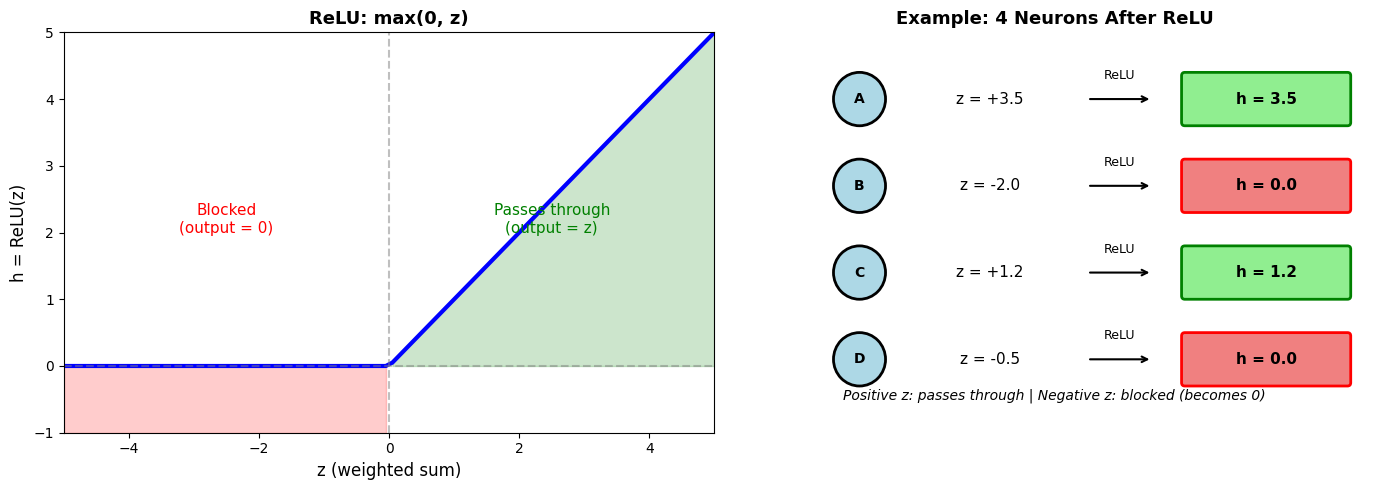

In [4]:
# Visualize ReLU activation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: ReLU function
ax1 = axes[0]
z = np.linspace(-5, 5, 100)
h = np.maximum(0, z)
ax1.plot(z, h, 'b-', linewidth=3)
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('z (weighted sum)', fontsize=12)
ax1.set_ylabel('h = ReLU(z)', fontsize=12)
ax1.set_title('ReLU: max(0, z)', fontsize=13, fontweight='bold')
ax1.set_xlim(-5, 5)
ax1.set_ylim(-1, 5)

# Annotate regions
ax1.fill_between(z[z<0], 0, -1, alpha=0.2, color='red')
ax1.fill_between(z[z>0], 0, h[z>0], alpha=0.2, color='green')
ax1.text(-2.5, 2, 'Blocked\n(output = 0)', fontsize=11, ha='center', color='red')
ax1.text(2.5, 2, 'Passes through\n(output = z)', fontsize=11, ha='center', color='green')

# Right panel: Example with feature detectors
ax2 = axes[1]
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 6)
ax2.axis('off')
ax2.set_title('Example: 4 Neurons After ReLU', fontsize=13, fontweight='bold')

# Show 4 example neurons with their z values and outputs
examples = [
    ('Neuron A', 3.5, 3.5, 'green'),   # positive -> passes
    ('Neuron B', -2.0, 0.0, 'red'),    # negative -> blocked
    ('Neuron C', 1.2, 1.2, 'green'),   # positive -> passes
    ('Neuron D', -0.5, 0.0, 'red'),    # negative -> blocked
]

for idx, (name, z_val, h_val, color) in enumerate(examples):
    y_pos = 5 - idx * 1.3
    
    # Neuron circle
    circle = plt.Circle((2, y_pos), 0.4, color='lightblue', ec='black', linewidth=2)
    ax2.add_patch(circle)
    ax2.text(2, y_pos, name[-1], ha='center', va='center', fontsize=10, fontweight='bold')
    
    # z value
    ax2.text(4, y_pos, f'z = {z_val:+.1f}', fontsize=11, ha='center', va='center')
    
    # Arrow
    ax2.annotate('', xy=(6.5, y_pos), xytext=(5.5, y_pos),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
    ax2.text(6, y_pos + 0.3, 'ReLU', fontsize=9, ha='center')
    
    # Output
    bg_color = 'lightgreen' if color == 'green' else 'lightcoral'
    ax2.add_patch(mpatches.FancyBboxPatch((7, y_pos - 0.35), 2.5, 0.7, 
                  boxstyle='round,pad=0.05', facecolor=bg_color, edgecolor=color, linewidth=2))
    ax2.text(8.25, y_pos, f'h = {h_val:.1f}', ha='center', va='center', fontsize=11, fontweight='bold')

ax2.text(5, 0.5, 'Positive z: passes through | Negative z: blocked (becomes 0)', 
         fontsize=10, ha='center', style='italic')

plt.tight_layout()
plt.show()


### Now Let's See Pattern Detection in Action

Below we show how the weights create a "template" that the neuron matches against:


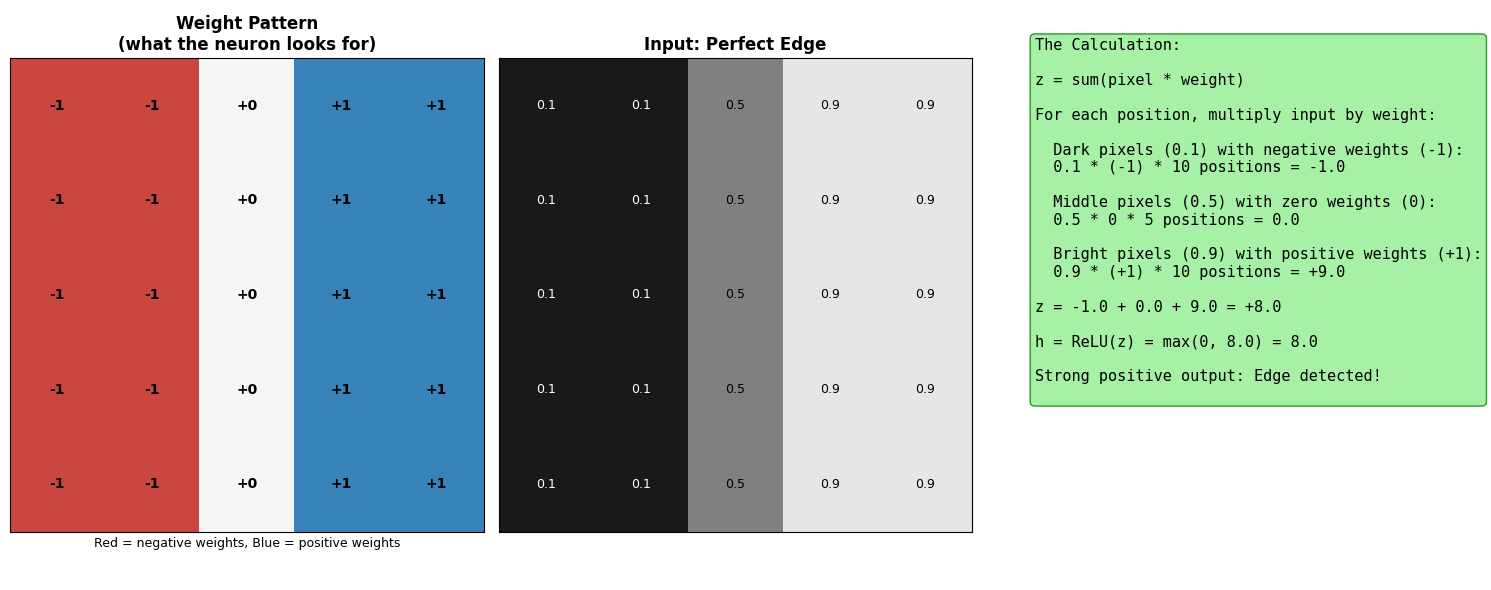

In [5]:
# Show neuron as edge detector
fig = plt.figure(figsize=(16, 6))

# Panel 1: The weight pattern
ax1 = fig.add_subplot(1, 3, 1)
weights_2d = np.array([[-1, -1, 0, 1, 1]]*5)
im = ax1.imshow(weights_2d, cmap='RdBu', vmin=-1.5, vmax=1.5)
ax1.set_title('Weight Pattern\n(what the neuron looks for)', fontsize=12, fontweight='bold')
for i in range(5):
    for j in range(5):
        ax1.text(j, i, f'{weights_2d[i,j]:+d}', ha='center', va='center', fontsize=10, fontweight='bold')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel('Red = negative weights, Blue = positive weights', fontsize=9)

# Panel 2: Perfect edge input
ax2 = fig.add_subplot(1, 3, 2)
edge_input = np.array([[0.1, 0.1, 0.5, 0.9, 0.9]]*5)
ax2.imshow(edge_input, cmap='gray', vmin=0, vmax=1)
ax2.set_title('Input: Perfect Edge', fontsize=12, fontweight='bold')
for i in range(5):
    for j in range(5):
        ax2.text(j, i, f'{edge_input[i,j]:.1f}', ha='center', va='center', fontsize=9, 
                color='white' if edge_input[i,j] < 0.5 else 'black')
ax2.set_xticks([])
ax2.set_yticks([])

# Panel 3: Calculation
ax3 = fig.add_subplot(1, 3, 3)
ax3.axis('off')

# Calculate the weighted sum
weights_flat = weights_2d.flatten()
input_flat = edge_input.flatten()
weighted_sum = np.sum(weights_flat * input_flat)
relu_output = max(0, weighted_sum)

calc_text = '''The Calculation:

z = sum(pixel * weight)

For each position, multiply input by weight:

  Dark pixels (0.1) with negative weights (-1):
  0.1 * (-1) * 10 positions = -1.0
  
  Middle pixels (0.5) with zero weights (0):
  0.5 * 0 * 5 positions = 0.0
  
  Bright pixels (0.9) with positive weights (+1):
  0.9 * (+1) * 10 positions = +9.0

z = -1.0 + 0.0 + 9.0 = +8.0

h = ReLU(z) = max(0, 8.0) = 8.0

Strong positive output: Edge detected!
'''
ax3.text(0.1, 0.95, calc_text, fontsize=11, family='monospace',
         verticalalignment='top', transform=ax3.transAxes,
         bbox=dict(boxstyle='round', facecolor='lightgreen', ec='green', alpha=0.8))

plt.tight_layout()
plt.show()


### Why This Works

The weights encode a **template**:
- **Negative weights** on the left say "I want dark pixels here"
- **Positive weights** on the right say "I want bright pixels here"

When the input **matches** the template:
- Dark * negative = positive contribution
- Bright * positive = positive contribution
- Sum is large and positive: **strong output**

When the input **doesn't match**:
- Bright * negative = negative contribution
- These cancel out or go negative
- ReLU blocks negative values: **zero output**


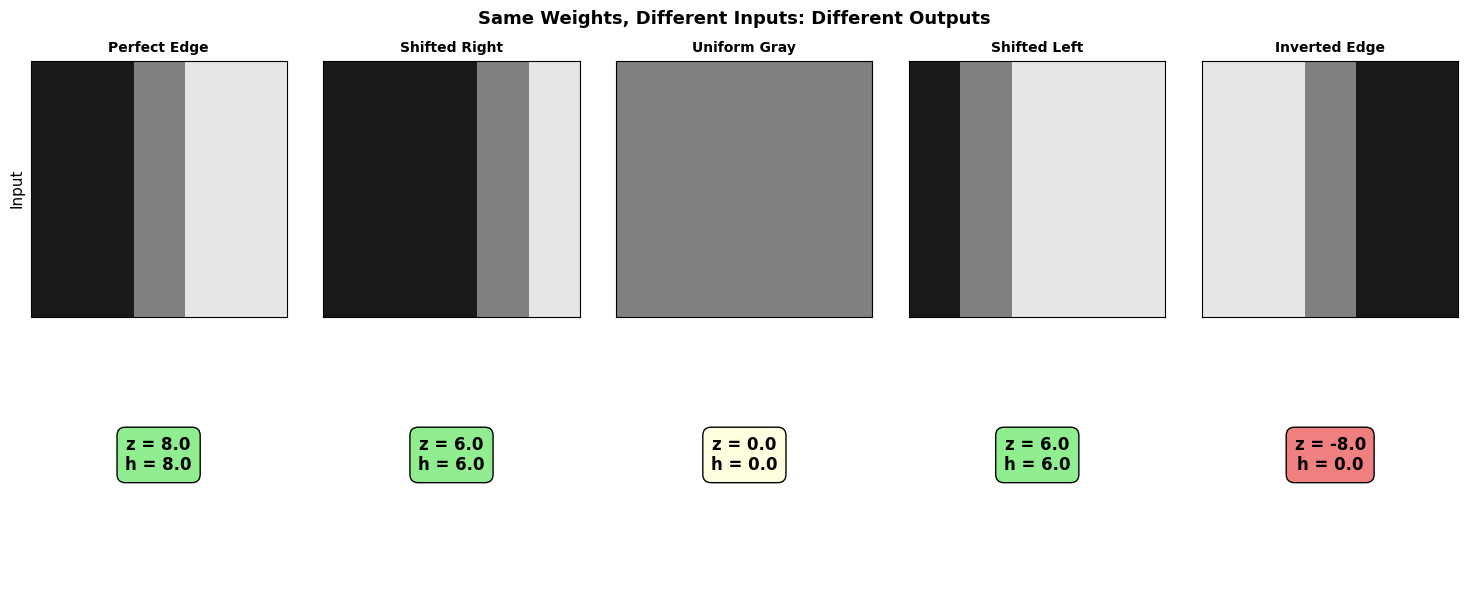

Key insight: The neuron responds most strongly when input matches the weight pattern!


In [6]:
# Show different inputs to same neuron
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

weights = np.array([-1, -1, 0, 1, 1])  # per column

test_cases = [
    ("Perfect Edge", [0.1, 0.1, 0.5, 0.9, 0.9]),
    ("Shifted Right", [0.1, 0.1, 0.1, 0.5, 0.9]),
    ("Uniform Gray", [0.5, 0.5, 0.5, 0.5, 0.5]),
    ("Shifted Left", [0.1, 0.5, 0.9, 0.9, 0.9]),
    ("Inverted Edge", [0.9, 0.9, 0.5, 0.1, 0.1]),
]

for idx, (name, pixels) in enumerate(test_cases):
    # Top row: show the input
    ax_top = axes[0, idx]
    img = np.array([pixels]*5)
    ax_top.imshow(img, cmap='gray', vmin=0, vmax=1)
    ax_top.set_title(name, fontsize=10, fontweight='bold')
    ax_top.set_xticks([])
    ax_top.set_yticks([])
    
    # Calculate output
    z = sum(p * w for p, w in zip(pixels, weights)) * 5  # 5 rows
    h = max(0, z)
    
    # Bottom row: show the calculation
    ax_bot = axes[1, idx]
    ax_bot.axis('off')
    
    color = 'lightgreen' if h > 0 else 'lightyellow' if z == 0 else 'lightcoral'
    result = f"z = {z:.1f}\nh = {h:.1f}"
    ax_bot.text(0.5, 0.5, result, ha='center', va='center', fontsize=12, fontweight='bold',
               transform=ax_bot.transAxes,
               bbox=dict(boxstyle='round,pad=0.5', facecolor=color, ec='black'))

axes[0, 0].set_ylabel('Input', fontsize=11)
axes[1, 0].set_ylabel('Output', fontsize=11)
plt.suptitle('Same Weights, Different Inputs: Different Outputs', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("Key insight: The neuron responds most strongly when input matches the weight pattern!")


---

## Part 3: From Scores to Probabilities - Softmax

We saw that neurons produce **scores** — higher means better pattern match. But for classification, we need **probabilities**: "What's the chance this is an edge?"

Our network has two output neurons (one for "Edge", one for "No Edge"), each producing a score. These raw scores (also called **logits**) can be any number — positive, negative, or zero.

**Softmax** converts these scores into proper probabilities that:
1. Are all positive
2. Sum to 1.0

### The Formula

$$P(\text{class } j) = \frac{e^{z_j}}{\sum_{k=1}^{n} e^{z_k}}$$

### Step by Step

The visualization below shows the 3-step process:
1. **Raw scores** — can be any numbers (positive, negative, zero)
2. **Exponentials** — $e^z$ makes everything positive
3. **Normalize** — divide by sum so they add to 1.0


**Implementation:** (end of forward pass)

```python
exp_scores = np.exp(scores - np.max(scores))  # exponentiate (stable)
probabilities = exp_scores / np.sum(exp_scores)  # normalize
```

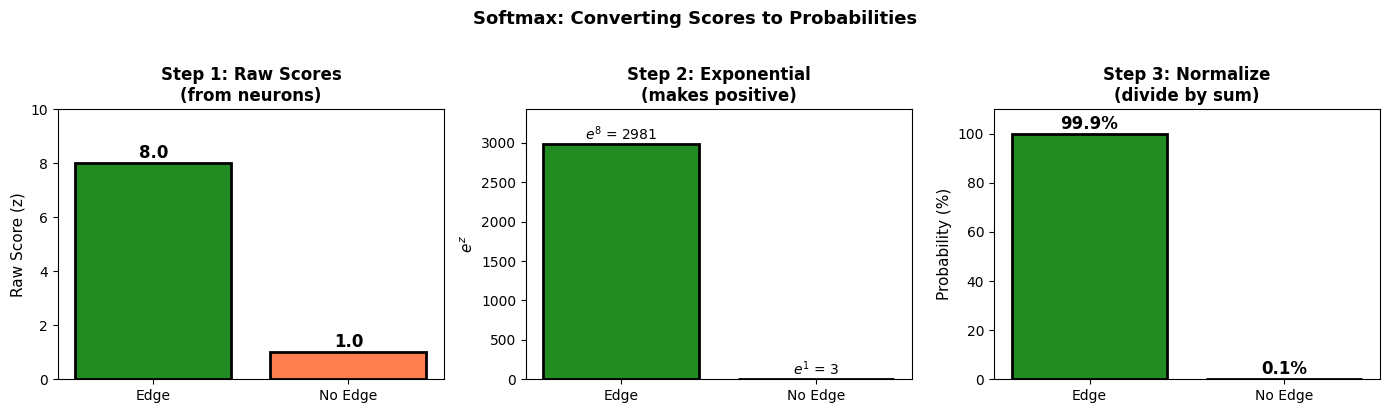

Result: P(Edge) = 99.9%, P(No Edge) = 0.1%
The network is 99.9% confident this is an edge.


In [7]:
# Show softmax with edge detection example
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Example scores for an edge image
scores = [8.0, 1.0]  # [Edge score, No Edge score]
labels = ['Edge', 'No Edge']
colors = ['forestgreen', 'coral']

# Step 1: Raw scores
ax1 = axes[0]
bars1 = ax1.bar(labels, scores, color=colors, edgecolor='black', linewidth=2)
ax1.set_ylabel('Raw Score (z)', fontsize=11)
ax1.set_title('Step 1: Raw Scores\n(from neurons)', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 10)
for bar, s in zip(bars1, scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, f'{s:.1f}', 
             ha='center', fontsize=12, fontweight='bold')

# Step 2: Exponentials
exp_scores = [np.exp(s) for s in scores]
ax2 = axes[1]
ax2.set_ylim(0, max(exp_scores) * 1.15)
bars2 = ax2.bar(labels, exp_scores, color=colors, edgecolor='black', linewidth=2)
ax2.set_ylabel('$e^z$', fontsize=11)
ax2.set_title('Step 2: Exponential\n(makes positive)', fontsize=12, fontweight='bold')
for bar, e, s in zip(bars2, exp_scores, scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, f'$e^{{{s:.0f}}}$ = {e:.0f}', 
             ha='center', fontsize=10)

# Step 3: Normalize
total = sum(exp_scores)
probs = [e/total * 100 for e in exp_scores]
ax3 = axes[2]
bars3 = ax3.bar(labels, probs, color=colors, edgecolor='black', linewidth=2)
ax3.set_ylabel('Probability (%)', fontsize=11)
ax3.set_title('Step 3: Normalize\n(divide by sum)', fontsize=12, fontweight='bold')
ax3.set_ylim(0, 110)
for bar, p in zip(bars3, probs):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{p:.1f}%', 
             ha='center', fontsize=12, fontweight='bold')

plt.suptitle(f'Softmax: Converting Scores to Probabilities', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"Result: P(Edge) = {probs[0]:.1f}%, P(No Edge) = {probs[1]:.1f}%")
print(f"The network is {probs[0]:.1f}% confident this is an edge.")


---

## Part 4: Measuring Wrongness - The Loss Function

Now we can measure how wrong the network is. We need a way to assign a number to "wrongness" — this is the **cross-entropy loss**.

### The Setup

Imagine our network outputs probabilities for our two classes:

| | P(Edge) | P(No Edge) | True Label | p_correct |
|---|---------|------------|------------|-----------|
| **Good prediction** | 0.95 | 0.05 | Edge | 0.95 |
| **Uncertain** | 0.5 | 0.5 | Edge | 0.5 |
| **Wrong prediction** | 0.1 | 0.9 | Edge | 0.1 |

In the "wrong" case, the network thinks it's probably **not** an edge (90%), but it actually **is** an edge. So we look at the probability it assigned to Edge (only 10%), and penalize heavily.

### The Formula

$$L = -\log(p_{\text{correct}})$$

We take the **negative log of the probability assigned to the correct class** — regardless of what the network thought the answer was.

### Why This Works

The chart below shows the loss curve. Notice how:
- High p_correct (near 1.0) → Low loss ✓
- Low p_correct (near 0.0) → Very high loss ✗

The **logarithm** is key — it severely punishes cases where the network assigned low probability to the correct answer!


**Implementation:** (after forward pass)

```python
loss = -np.sum(y_true * np.log(p_predicted + 1e-8))
```

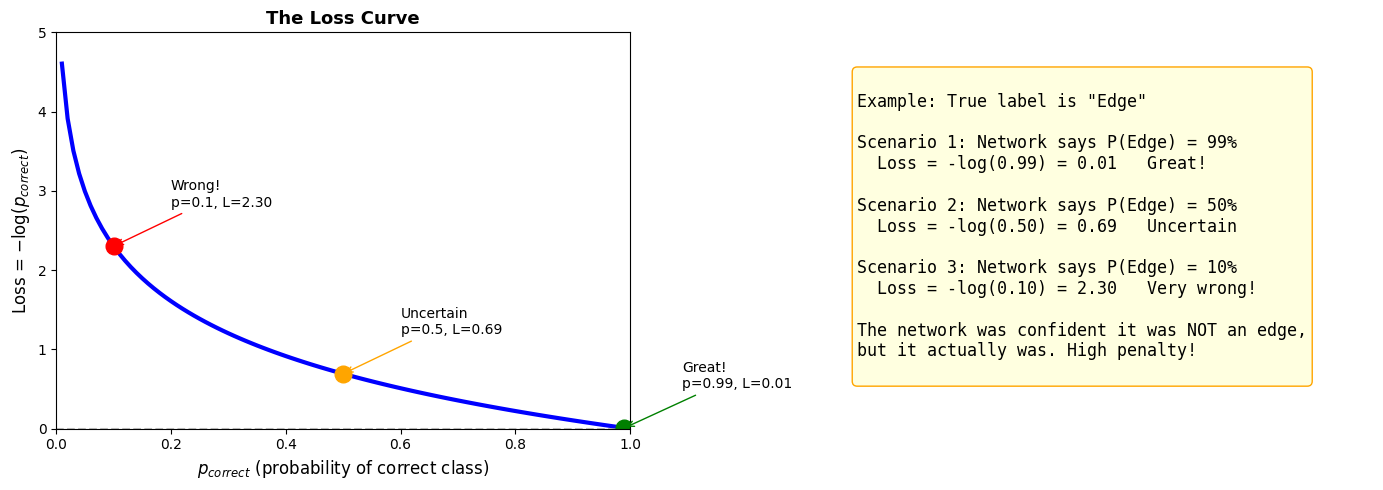

In [8]:
# Show loss function
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: The loss curve
ax1 = axes[0]
p = np.linspace(0.01, 1.0, 100)
loss = -np.log(p)
ax1.plot(p, loss, 'b-', linewidth=3)
ax1.set_xlabel('$p_{correct}$ (probability of correct class)', fontsize=12)
ax1.set_ylabel(r"Loss = $-\log(p_{correct})$", fontsize=12)
ax1.set_title('The Loss Curve', fontsize=13, fontweight='bold')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 5)
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Mark some points
points = [(0.99, 'Great!', 'green'), (0.5, 'Uncertain', 'orange'), (0.1, 'Wrong!', 'red')]
for p_val, label, color in points:
    l_val = -np.log(p_val)
    ax1.plot(p_val, l_val, 'o', markersize=12, color=color)
    ax1.annotate(f'{label}\np={p_val}, L={l_val:.2f}', xy=(p_val, l_val), 
                xytext=(p_val + 0.1, l_val + 0.5), fontsize=10,
                arrowprops=dict(arrowstyle='->', color=color))

# Right: Example scenarios
ax2 = axes[1]
ax2.axis('off')

scenarios = '''
Example: True label is "Edge"

Scenario 1: Network says P(Edge) = 99%
  Loss = -log(0.99) = 0.01   Great!
  
Scenario 2: Network says P(Edge) = 50%
  Loss = -log(0.50) = 0.69   Uncertain
  
Scenario 3: Network says P(Edge) = 10%
  Loss = -log(0.10) = 2.30   Very wrong!
  
The network was confident it was NOT an edge,
but it actually was. High penalty!
'''
ax2.text(0.1, 0.9, scenarios, fontsize=12, family='monospace',
         verticalalignment='top', transform=ax2.transAxes,
         bbox=dict(boxstyle='round', facecolor='lightyellow', ec='orange'))

plt.tight_layout()
plt.show()


### Why Logarithm?

The log has a special property: it **severely punishes confident wrong answers**.

- If p_correct = 0.99: Loss = 0.01 (tiny)
- If p_correct = 0.50: Loss = 0.69 (moderate)  
- If p_correct = 0.10: Loss = 2.30 (large)
- If p_correct = 0.01: Loss = 4.60 (huge!)

This makes sense: a network that says "I'm 99% sure it's NOT an edge" when it IS an edge should be penalized heavily.


### The Summation Trick

You might see the loss formula written as:

$$L = -\sum_{l} y_l \cdot \log(p_l)$$

This sums over all classes. But since $y$ is **one-hot encoded** (1 for the correct class, 0 for all others), only one term survives!

For example, if "Edge" is correct: $y = [1, 0]$

$$L = -(1 \cdot \log(p_{edge}) + 0 \cdot \log(p_{no\_edge})) = -\log(p_{edge})$$

The $y$ values act as a **selector** — picking out only the correct class's probability. This is why the loss simplifies to just $L = -\log(p_{correct})$.


---

## Part 5: Learning - How Do We Find the Right Weights?

So far we've assumed the weights are "correct" (negative on left, positive on right). But how does the network **learn** these weights from scratch?

The answer is **gradient descent**:
1. Start with random weights
2. Measure the loss (how wrong are we?)
3. Compute the **gradient** (which direction makes loss smaller?)
4. Update weights in that direction
5. Repeat!

### The Gradient

The gradient tells us: **if I increase this weight slightly, does the loss go up or down?**

$$\frac{\partial L}{\partial w} = \text{"how much does loss change when I change } w \text{?"}$$

- If gradient is **positive**: increasing w increases loss, so **decrease w**
- If gradient is **negative**: increasing w decreases loss, so **increase w**

### The Update Rule

$$w_{\text{new}} = w_{\text{old}} - \alpha \cdot \frac{\partial L}{\partial w}$$

We move **opposite** to the gradient (downhill), scaled by the learning rate $\alpha$.

### Terminology

- **Iteration**: One weight update (forward pass → compute loss → backward pass → update)
- **Epoch**: One complete pass through all training examples
- **Batch**: A subset of training data used for one iteration (for efficiency)

In our simple example below, each iteration uses one training example.


**Implementation:** (end of each iteration)

```python
W = W - learning_rate * dL_dW  # update weights
b = b - learning_rate * dL_db  # update bias
```

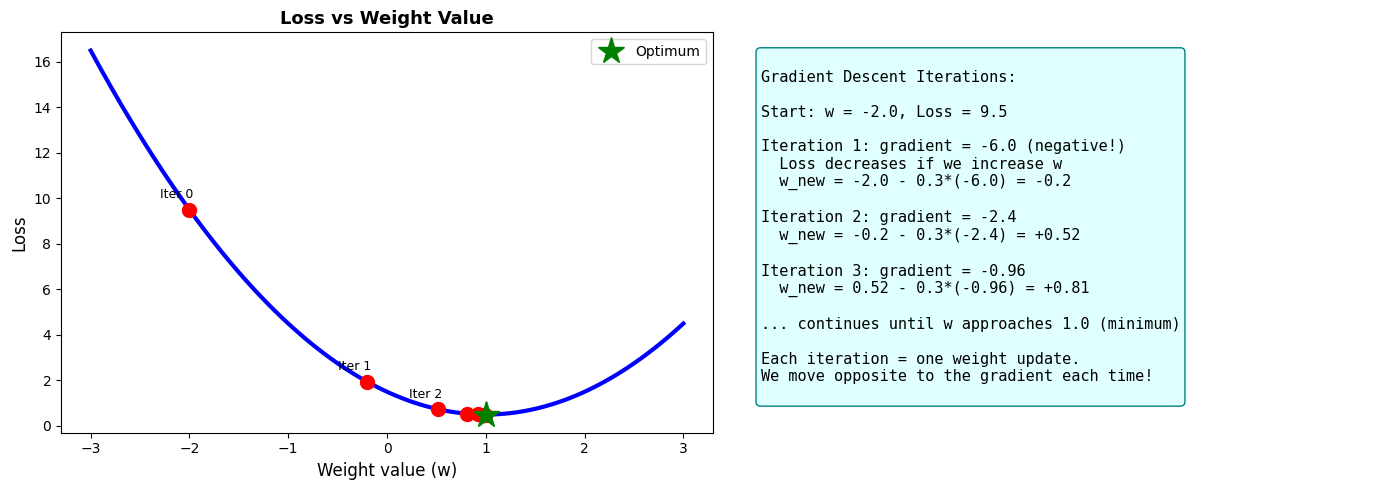

Terminology:
  - Iteration: one weight update (compute gradient, update weights)
  - Epoch: one full pass through all training data
  - Batch: a subset of training data used per iteration


In [9]:
# Visualize gradient descent on a simple 1D example
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Loss landscape
ax1 = axes[0]
w = np.linspace(-3, 3, 100)
# Simple quadratic loss for illustration
loss = (w - 1)**2 + 0.5
ax1.plot(w, loss, 'b-', linewidth=3)
ax1.set_xlabel('Weight value (w)', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss vs Weight Value', fontsize=13, fontweight='bold')

# Show gradient descent steps
w_start = -2.0
learning_rate = 0.3
w_history = [w_start]
for i in range(8):
    w_current = w_history[-1]
    gradient = 2 * (w_current - 1)  # derivative of (w-1)^2
    w_new = w_current - learning_rate * gradient
    w_history.append(w_new)

for i, w_val in enumerate(w_history[:-1]):
    loss_val = (w_val - 1)**2 + 0.5
    ax1.plot(w_val, loss_val, 'ro', markersize=10)
    if i < 3:
        ax1.annotate(f'Iter {i}', xy=(w_val, loss_val), xytext=(w_val-0.3, loss_val+0.5), fontsize=9)

ax1.plot(1, 0.5, 'g*', markersize=20, label='Optimum')
ax1.legend()

# Right: The update process
ax2 = axes[1]
ax2.axis('off')

update_text = """
Gradient Descent Iterations:

Start: w = -2.0, Loss = 9.5

Iteration 1: gradient = -6.0 (negative!)
  Loss decreases if we increase w
  w_new = -2.0 - 0.3*(-6.0) = -0.2

Iteration 2: gradient = -2.4
  w_new = -0.2 - 0.3*(-2.4) = +0.52
  
Iteration 3: gradient = -0.96
  w_new = 0.52 - 0.3*(-0.96) = +0.81
  
... continues until w approaches 1.0 (minimum)

Each iteration = one weight update.
We move opposite to the gradient each time!
"""
ax2.text(0.05, 0.95, update_text, fontsize=11, family='monospace',
         verticalalignment='top', transform=ax2.transAxes,
         bbox=dict(boxstyle='round', facecolor='lightcyan', ec='teal'))

plt.tight_layout()
plt.show()

print("Terminology:")
print("  - Iteration: one weight update (compute gradient, update weights)")
print("  - Epoch: one full pass through all training data")
print("  - Batch: a subset of training data used per iteration")


---

## Part 6: Backpropagation - Computing Gradients in a Network

In Part 5, we saw the update rule requires the gradient $\frac{\partial L}{\partial w}$ for each weight. But our network has **many weights** — how do we compute all these gradients efficiently?

The answer is **backpropagation**, which uses the **chain rule** from calculus. Since the network is a chain of functions:

$$\text{input} \rightarrow \text{layer 1} \rightarrow \text{layer 2} \rightarrow \text{output} \rightarrow \text{loss}$$

The gradient for a weight in layer 1 is:

$$\frac{\partial L}{\partial w_1} = \frac{\partial L}{\partial \text{output}} \cdot \frac{\partial \text{output}}{\partial \text{layer2}} \cdot \frac{\partial \text{layer2}}{\partial \text{layer1}} \cdot \frac{\partial \text{layer1}}{\partial w_1}$$

We **multiply** the gradients along the path from loss back to the weight. This is why it's called "back" propagation — we start at the loss and work backwards.


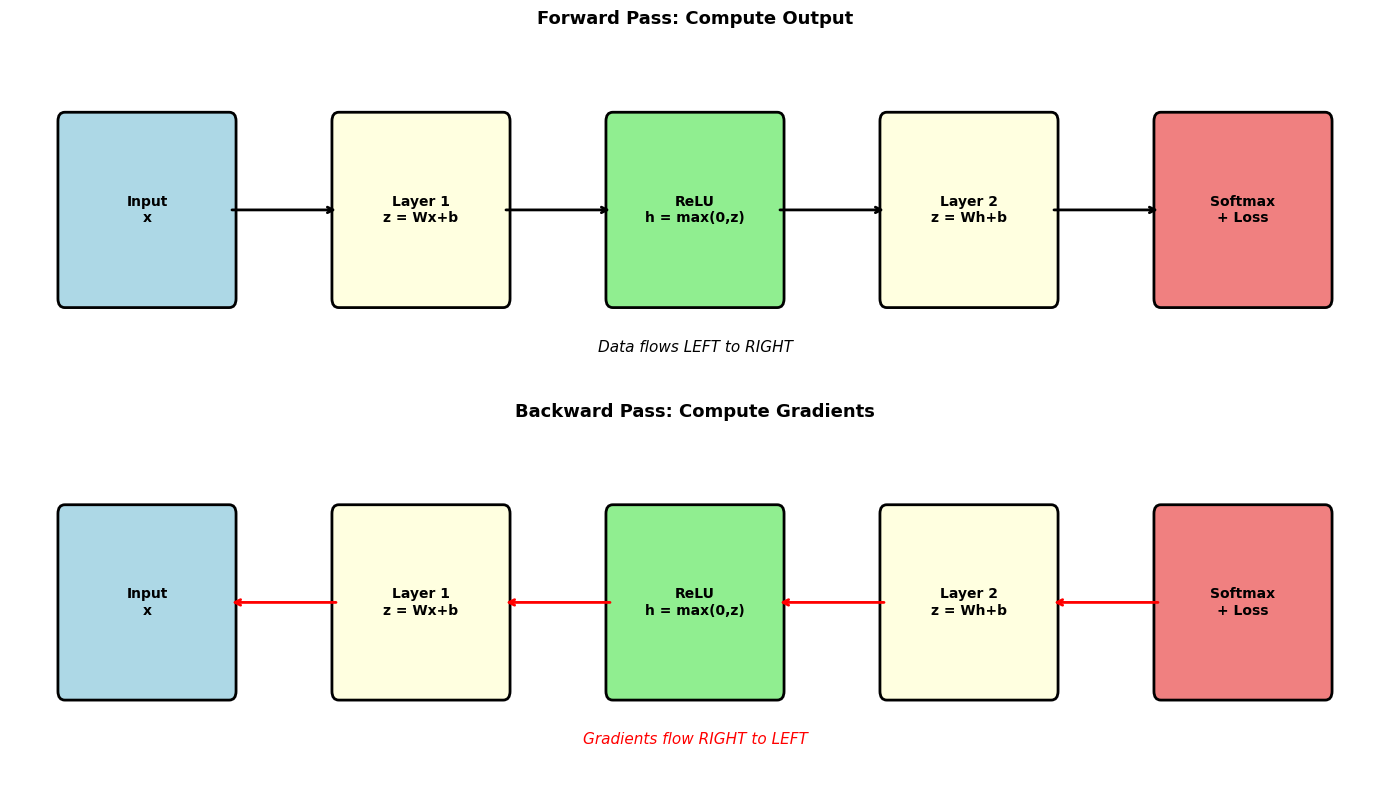

In [10]:
# Show forward and backward pass
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Forward pass
ax1 = axes[0]
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 2)
ax1.axis('off')
ax1.set_title('Forward Pass: Compute Output', fontsize=13, fontweight='bold')

boxes = [
    (1, 'Input\nx', 'lightblue'),
    (3, 'Layer 1\nz = Wx+b', 'lightyellow'),
    (5, 'ReLU\nh = max(0,z)', 'lightgreen'),
    (7, 'Layer 2\nz = Wh+b', 'lightyellow'),
    (9, 'Softmax\n+ Loss', 'lightcoral'),
]

for x, text, color in boxes:
    ax1.add_patch(mpatches.FancyBboxPatch((x-0.6, 0.5), 1.2, 1, boxstyle='round,pad=0.05', 
                                          facecolor=color, edgecolor='black', linewidth=2))
    ax1.text(x, 1, text, ha='center', va='center', fontsize=10, fontweight='bold')

for i in range(len(boxes)-1):
    ax1.annotate('', xy=(boxes[i+1][0]-0.6, 1), xytext=(boxes[i][0]+0.6, 1),
                arrowprops=dict(arrowstyle='->', color='black', lw=2))

ax1.text(5, 0.2, 'Data flows LEFT to RIGHT', ha='center', fontsize=11, style='italic')

# Backward pass
ax2 = axes[1]
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 2)
ax2.axis('off')
ax2.set_title('Backward Pass: Compute Gradients', fontsize=13, fontweight='bold')

for x, text, color in boxes:
    ax2.add_patch(mpatches.FancyBboxPatch((x-0.6, 0.5), 1.2, 1, boxstyle='round,pad=0.05', 
                                          facecolor=color, edgecolor='black', linewidth=2))
    ax2.text(x, 1, text, ha='center', va='center', fontsize=10, fontweight='bold')

for i in range(len(boxes)-1):
    ax2.annotate('', xy=(boxes[i][0]+0.6, 1), xytext=(boxes[i+1][0]-0.6, 1),
                arrowprops=dict(arrowstyle='->', color='red', lw=2))

ax2.text(5, 0.2, 'Gradients flow RIGHT to LEFT', ha='center', fontsize=11, style='italic', color='red')

plt.tight_layout()
plt.show()


### The Key Gradients

For our edge detector, here are the key gradients:

**At the output (softmax + cross-entropy combined):**
$$\frac{\partial L}{\partial z_{output}} = p_{predicted} - y_{true}$$

This is beautifully simple! If true label is "Edge" (y=[1,0]) and prediction is [0.9, 0.1]:
- Gradient for Edge score: 0.9 - 1 = -0.1 (negative → want to **increase** this score)
- Gradient for No-Edge score: 0.1 - 0 = +0.1 (positive → want to **decrease** this score)

**Through ReLU:**
$$\frac{\partial h}{\partial z} = \begin{cases} 1 & \text{if } z > 0 \\ 0 & \text{if } z \leq 0 \end{cases}$$

ReLU either passes the gradient through (if neuron was active) or blocks it (if neuron was off).

**For a weight:**
$$\frac{\partial L}{\partial W} = \text{(input to this layer)}^T \cdot \text{(gradient from layer above)}$$

### How Gradients Update Weights

Once we have $\frac{\partial L}{\partial W}$ for each weight, we apply the update rule:

$$W_{new} = W_{old} - \alpha \cdot \frac{\partial L}{\partial W}$$

**Concrete example:** Say a weight $w = 0.5$ and its gradient $\frac{\partial L}{\partial w} = -0.2$

With learning rate $\alpha = 0.1$:
$$w_{new} = 0.5 - 0.1 \times (-0.2) = 0.5 + 0.02 = 0.52$$

The gradient was **negative**, meaning "increasing this weight decreases the loss" — so we increased it!

This happens for **every weight** in the network, every iteration. Over thousands of iterations, the weights gradually move toward values that minimize the loss.


**Implementation:** (backward pass, after computing loss)

```python
dL_dz = p_predicted - y_true   # output layer gradient
dL_dW = inputs.T @ dL_dz       # weight gradient  
dL_db = dL_dz                  # bias gradient
```

---

## Part 7: Watching It Learn

Let's put it all together! We'll train a tiny network on an edge detection task and watch the loss decrease.


**The Training Loop Structure:**

```python
for epoch in range(num_epochs):           # repeat many times
    for x, y in training_data:            # for each example
        
        # Forward pass
        z = x @ W + b                     # weighted sum
        p = softmax(z)                    # probabilities
        loss = -np.sum(y * np.log(p))     # measure error
        
        # Backward pass  
        dL_dz = p - y                     # output gradient
        dL_dW = x.T @ dL_dz               # weight gradient
        dL_db = dL_dz                     # bias gradient
        
        # Update
        W = W - lr * dL_dW                # adjust weights
        b = b - lr * dL_db                # adjust bias
```

Each piece we've learned slots into this loop. Let's see it in action:

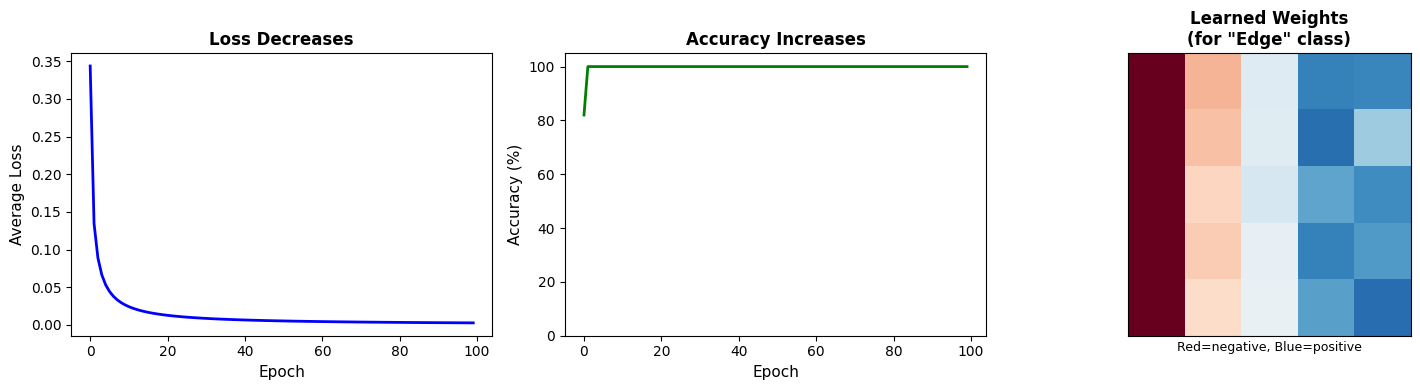

Final accuracy: 100.0%

The network learned weights that are negative on the left and positive on the right!
This is exactly the pattern we would expect for an edge detector.


In [11]:
# Train a simple edge detector
np.random.seed(42)

# Create training data: 5x5 patches
def make_edge_patch():
    # Random position for edge (columns 1-3)
    edge_col = np.random.randint(1, 4)
    patch = np.ones((5, 5)) * 0.1  # dark
    patch[:, edge_col:] = 0.9  # bright on right
    return patch.flatten(), np.array([1, 0])  # label: Edge

def make_no_edge_patch():
    # Either uniform or inverted
    if np.random.rand() > 0.5:
        val = np.random.uniform(0.3, 0.7)
        patch = np.ones((5, 5)) * val
    else:
        patch = np.ones((5, 5)) * 0.9
        patch[:, 2:] = 0.1  # bright to dark (inverted)
    return patch.flatten(), np.array([0, 1])  # label: No Edge

# Generate dataset
X_train = []
y_train = []
for _ in range(50):
    if np.random.rand() > 0.5:
        x, y = make_edge_patch()
    else:
        x, y = make_no_edge_patch()
    X_train.append(x)
    y_train.append(y)
X_train = np.array(X_train)
y_train = np.array(y_train)

# Initialize network (simplified: just one layer for this demo)
W = np.random.randn(25, 2) * 0.1  # 25 inputs -> 2 outputs
b = np.zeros((1, 2))

# Training
learning_rate = 0.1
losses = []
accuracies = []

for epoch in range(100):
    epoch_loss = 0
    correct = 0
    
    for i in range(len(X_train)):
        x = X_train[i:i+1]
        y = y_train[i:i+1]
        
        # Forward pass
        z = x @ W + b
        exp_z = np.exp(z - np.max(z))
        p = exp_z / np.sum(exp_z)
        
        # Loss
        loss = -np.sum(y * np.log(p + 1e-8))
        epoch_loss += loss
        
        # Accuracy
        if np.argmax(p) == np.argmax(y):
            correct += 1
        
        # Backward pass
        dL_dz = p - y
        dL_dW = x.T @ dL_dz
        dL_db = dL_dz
        
        # Update
        W -= learning_rate * dL_dW
        b -= learning_rate * dL_db
    
    losses.append(epoch_loss / len(X_train))
    accuracies.append(correct / len(X_train) * 100)

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss curve
axes[0].plot(losses, 'b-', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Average Loss', fontsize=11)
axes[0].set_title('Loss Decreases', fontsize=12, fontweight='bold')

# Accuracy curve
axes[1].plot(accuracies, 'g-', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('Accuracy (%)', fontsize=11)
axes[1].set_title('Accuracy Increases', fontsize=12, fontweight='bold')
axes[1].set_ylim(0, 105)

# Learned weights
axes[2].imshow(W[:, 0].reshape(5, 5), cmap='RdBu', vmin=-1, vmax=1)
axes[2].set_title('Learned Weights\n(for "Edge" class)', fontsize=12, fontweight='bold')
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_xlabel('Red=negative, Blue=positive', fontsize=9)

plt.tight_layout()
plt.show()

print(f"Final accuracy: {accuracies[-1]:.1f}%")
print(f"\nThe network learned weights that are negative on the left and positive on the right!")
print("This is exactly the pattern we would expect for an edge detector.")


### What Happened?

1. We started with **random weights**
2. The network made predictions (mostly wrong at first)
3. We computed the **loss** (high initially)
4. We computed **gradients** via backpropagation
5. We **updated weights** to reduce loss
6. After 100 epochs, the network learned to detect edges!

Look at the learned weights in the rightmost plot. They show the same pattern we designed by hand earlier: negative (red) on the left, positive (blue) on the right. **The network discovered that edge detection requires this weight pattern!**


---

## Try It Yourself: Complete Edge Detector in ~60 Lines

Here's a self-contained example you can copy and run. It includes everything: data generation, network initialization, forward pass, backward pass, and training loop.


In [12]:
"""
Complete Neural Network Edge Detector
=====================================
A minimal, self-contained example using only NumPy.
Copy this code and run it yourself!
"""

import numpy as np

# ============================================================
# 1. CREATE TRAINING DATA
# ============================================================
np.random.seed(42)

def make_data(n_samples=100):
    """Generate edge and non-edge image patches."""
    X, y = [], []
    for _ in range(n_samples):
        if np.random.rand() > 0.5:
            # Edge: dark on left, bright on right
            edge_pos = np.random.randint(1, 4)
            patch = np.ones((5, 5)) * 0.1
            patch[:, edge_pos:] = 0.9
            label = [1, 0]  # Edge
        else:
            # No edge: uniform or inverted
            if np.random.rand() > 0.5:
                patch = np.ones((5, 5)) * np.random.uniform(0.3, 0.7)
            else:
                patch = np.ones((5, 5)) * 0.9
                patch[:, 2:] = 0.1  # bright-to-dark (not an edge)
            label = [0, 1]  # No Edge
        X.append(patch.flatten())
        y.append(label)
    return np.array(X), np.array(y)

X_train, y_train = make_data(100)
X_test, y_test = make_data(20)

# ============================================================
# 2. INITIALIZE NETWORK
# ============================================================
# Simple network: 25 inputs -> 2 outputs (no hidden layer)
W = np.random.randn(25, 2) * 0.1
b = np.zeros((1, 2))
learning_rate = 0.1

# ============================================================
# 3. DEFINE FORWARD AND BACKWARD PASS
# ============================================================
def softmax(z):
    exp_z = np.exp(z - np.max(z))  # subtract max for numerical stability
    return exp_z / np.sum(exp_z)

def forward(x):
    """Forward pass: input -> scores -> probabilities"""
    z = x @ W + b          # weighted sum + bias
    p = softmax(z)         # softmax to get probabilities
    return z, p

def compute_loss(p, y):
    """Cross-entropy loss"""
    return -np.sum(y * np.log(p + 1e-8))

def backward(x, p, y):
    """Backward pass: compute gradients"""
    dL_dz = p - y                    # gradient at output (softmax + CE combined)
    dL_dW = x.T @ dL_dz              # gradient for weights
    dL_db = dL_dz                    # gradient for bias
    return dL_dW, dL_db

# ============================================================
# 4. TRAINING LOOP
# ============================================================
print("Training...")
for epoch in range(50):
    total_loss = 0
    for i in range(len(X_train)):
        x = X_train[i:i+1]
        y = y_train[i:i+1]
        
        # Forward
        z, p = forward(x)
        loss = compute_loss(p, y)
        total_loss += loss
        
        # Backward
        dL_dW, dL_db = backward(x, p, y)
        
        # Update weights
        W -= learning_rate * dL_dW
        b -= learning_rate * dL_db
    
    if epoch % 10 == 0:
        print(f"  Epoch {epoch:2d}: Loss = {total_loss/len(X_train):.4f}")

# ============================================================
# 5. EVALUATE ON TEST SET
# ============================================================
correct = 0
for i in range(len(X_test)):
    _, p = forward(X_test[i:i+1])
    if np.argmax(p) == np.argmax(y_test[i]):
        correct += 1

print(f"\nTest Accuracy: {correct}/{len(X_test)} = {100*correct/len(X_test):.1f}%")

# ============================================================
# 6. VISUALIZE LEARNED WEIGHTS
# ============================================================
print("\nLearned weights for 'Edge' class (reshaped to 5x5):")
edge_weights = W[:, 0].reshape(5, 5)
print(np.round(edge_weights, 2))
print("\nNotice: negative on left (wants dark), positive on right (wants bright)!")
print("The network discovered the edge detection pattern automatically.")


Training...
  Epoch  0: Loss = 0.2196
  Epoch 10: Loss = 0.0120
  Epoch 20: Loss = 0.0062
  Epoch 30: Loss = 0.0042
  Epoch 40: Loss = 0.0032

Test Accuracy: 20/20 = 100.0%

Learned weights for 'Edge' class (reshaped to 5x5):
[[-1.55 -0.3   0.08  0.6   0.6 ]
 [-1.68 -0.21  0.16  0.69  0.44]
 [-1.54 -0.16  0.18  0.67  0.55]
 [-1.67 -0.26  0.35  0.65  0.53]
 [-1.59 -0.28  0.05  0.58  0.79]]

Notice: negative on left (wants dark), positive on right (wants bright)!
The network discovered the edge detection pattern automatically.


---

## Summary

We've built up a complete picture of how neural networks learn:

**The Forward Pass:**
1. **Neurons** compute weighted sums + activation
2. **Softmax** converts scores to probabilities
3. **Loss** measures how wrong we are

**The Backward Pass:**
4. **Gradients** tell us which direction to adjust weights
5. **Backpropagation** uses the chain rule to compute all gradients
6. **Gradient descent** updates weights to reduce loss

**Key Formulas:**
- Neuron: $h = \max(0, \sum_i x_i w_i + b)$
- Softmax: $P_j = \frac{e^{z_j}}{\sum_k e^{z_k}}$
- Loss: $L = -\log(p_{correct})$
- Update: $w \leftarrow w - \alpha \frac{\partial L}{\partial w}$

**The Magic:** By repeating forward-pass, loss, backward-pass, update thousands of times, the network discovers the right weights automatically!

---

**Further Reading:**
- [How Neural Networks Learn to See](https://snowch.github.io/nn_edge_detector_blog.html) — Deep dive into how a single neuron detects patterns (weights, ReLU, bias)
- [3Blue1Brown Neural Networks](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi) — Excellent video explanations
